# New version

In [1]:
import assignment3 as neu
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))#[:1000,]
train_images = (train_images.astype('float32') / 255)
test_images = test_images.reshape((10000, 28 * 28))#[:1000,]
test_images = (test_images.astype('float32') / 255)


In [3]:
train_images.shape

(60000, 784)

In [4]:
train_labels = to_categorical(train_labels)#[:1000,]
test_labels = to_categorical(test_labels)#[:1000,]

In [5]:
first_network = neu.NeuralNetwork('categorical_crossentropy')
first_network.add_layer(28*28, 128,'relu')
# first_network.add_layer(128, 64,'sigmoid')
first_network.add_layer(128, 10,'softmax')

In [6]:
#lista liczb neuronów i żeby samo się utworzyło
#zbiór obserwacji podzielić na wsady (2**... czy po sto), po każdej liczymy gradient ale wagi updatujemy na koniec, rozmiar batcha żeby się dało podać (ostatni batch to to zostało jak zbiór się nie dZieli)
#funkcja aktywacji czy funkcja kosztu do wyboru
first_network.fit(train_images, train_labels, epochs=10, learning_rate=.01, val=(test_images, test_labels))

epoch: 1, loss: [0.58757652], acc: 0.8917
val_loss: [0.26293848], val_acc: 0.9309
epoch: 2, loss: [0.21947316], acc: 0.9399333333333333
val_loss: [0.22145071], val_acc: 0.9437
epoch: 3, loss: [0.16631467], acc: 0.9534166666666667
val_loss: [0.1869443], val_acc: 0.949
epoch: 4, loss: [0.128859], acc: 0.96355
val_loss: [0.18019243], val_acc: 0.9529
epoch: 5, loss: [0.11022669], acc: 0.9684666666666667
val_loss: [0.19271107], val_acc: 0.9557
epoch: 6, loss: [0.09217782], acc: 0.9725166666666667
val_loss: [0.17801078], val_acc: 0.9583
epoch: 7, loss: [0.08083247], acc: 0.9758666666666667
val_loss: [0.17814605], val_acc: 0.9617
epoch: 8, loss: [0.06688223], acc: 0.9792333333333333
val_loss: [0.18225672], val_acc: 0.9608
epoch: 9, loss: [0.05817121], acc: 0.9818666666666667
val_loss: [0.18146361], val_acc: 0.9621
epoch: 10, loss: [0.05165625], acc: 0.9840666666666666
val_loss: [0.18138979], val_acc: 0.9604


Text(0, 0.5, 'loss')

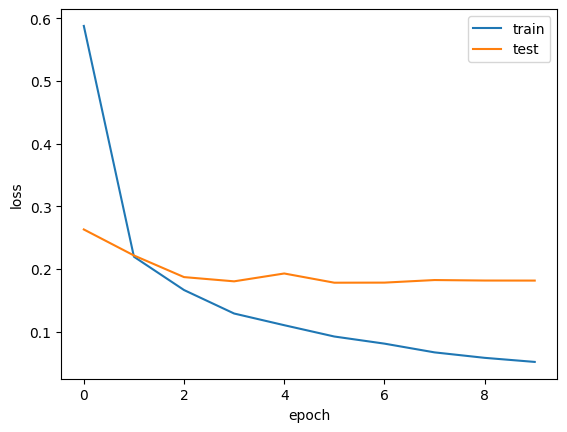

In [7]:
plt.plot(first_network.loss, label='train')
plt.plot(first_network.val_loss, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'acc')

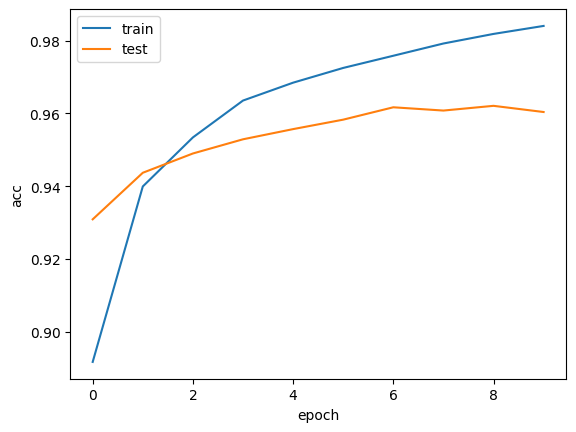

In [8]:
plt.plot(first_network.acc, label='train')
plt.plot(first_network.val_acc, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')

In [9]:
predicted = first_network.predict(test_images, test_labels)

In [11]:
first_network.test_acc

0.9604

In [12]:
first_network.test_loss

array([0.18138979])

# Second model

In [13]:
second_network = neu.NeuralNetwork('categorical_crossentropy')
second_network.add_layer(28*28, 128,'relu')
second_network.add_layer(128, 64,'sigmoid')
second_network.add_layer(64, 10,'softmax')

# Is it okay that train acc is before weight adjustment but val_acc is after??

In [14]:
second_network.fit(train_images, train_labels, epochs=10, learning_rate=.01, val=(test_images, test_labels))


epoch: 1, loss: [0.51447291], acc: 0.8392333333333334
val_loss: [0.31945998], val_acc: 0.9026
epoch: 2, loss: [0.27664262], acc: 0.9160333333333334
val_loss: [0.22860134], val_acc: 0.9312
epoch: 3, loss: [0.22017096], acc: 0.9329166666666666
val_loss: [0.19632233], val_acc: 0.9407
epoch: 4, loss: [0.18293901], acc: 0.94505
val_loss: [0.17238155], val_acc: 0.9501
epoch: 5, loss: [0.15822713], acc: 0.9520166666666666
val_loss: [0.16606897], val_acc: 0.9511
epoch: 6, loss: [0.13763004], acc: 0.9579666666666666
val_loss: [0.15889706], val_acc: 0.9515
epoch: 7, loss: [0.12345596], acc: 0.9623666666666667
val_loss: [0.14561793], val_acc: 0.958
epoch: 8, loss: [0.1119478], acc: 0.9662833333333334
val_loss: [0.14058839], val_acc: 0.9593
epoch: 9, loss: [0.10108593], acc: 0.9684
val_loss: [0.13503278], val_acc: 0.9609
epoch: 10, loss: [0.09022668], acc: 0.9721
val_loss: [0.13847145], val_acc: 0.9582


Text(0, 0.5, 'loss')

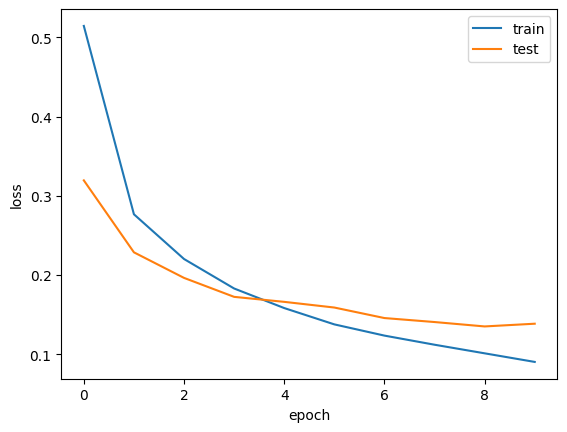

In [15]:
plt.plot(second_network.loss, label='train')
plt.plot(second_network.val_loss, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'acc')

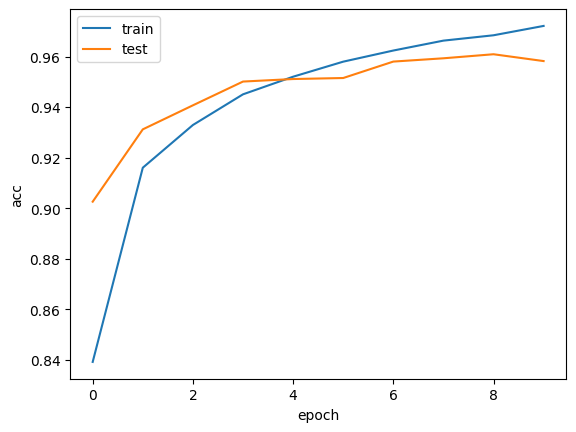

In [16]:
plt.plot(second_network.acc, label='train')
plt.plot(second_network.val_acc, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')

# Third model

In [17]:
third_network = neu.NeuralNetwork('mse')
third_network.add_layer(28*28, 128,'relu')
third_network.add_layer(128, 64,'sigmoid')
third_network.add_layer(64, 10,'softmax')

In [18]:
third_network.fit(train_images, train_labels, epochs=10, learning_rate=.01, val=(test_images, test_labels))


epoch: 1, loss: 0.035072893342895234, acc: 0.7482
val_loss: 0.020546369664993683, val_acc: 0.8613
epoch: 2, loss: 0.018515959827426553, acc: 0.8746833333333334
val_loss: 0.01622718086336941, val_acc: 0.8912
epoch: 3, loss: 0.015008248585474079, acc: 0.89955
val_loss: 0.01375835986036777, val_acc: 0.9058
epoch: 4, loss: 0.012998879018889674, acc: 0.9134833333333333
val_loss: 0.01241049608451259, val_acc: 0.9174
epoch: 5, loss: 0.011650518664424552, acc: 0.9223166666666667
val_loss: 0.011570436295716219, val_acc: 0.9219
epoch: 6, loss: 0.01059787786049695, acc: 0.9295333333333333
val_loss: 0.010877014823601162, val_acc: 0.9275
epoch: 7, loss: 0.009783240895795684, acc: 0.9363
val_loss: 0.010537070885657038, val_acc: 0.9292
epoch: 8, loss: 0.009106897681039018, acc: 0.9407833333333333
val_loss: 0.010002563329763845, val_acc: 0.9338
epoch: 9, loss: 0.008541613380190178, acc: 0.9439666666666666
val_loss: 0.009855351841259276, val_acc: 0.9342
epoch: 10, loss: 0.00806668777117346, acc: 0.9466

Text(0, 0.5, 'loss')

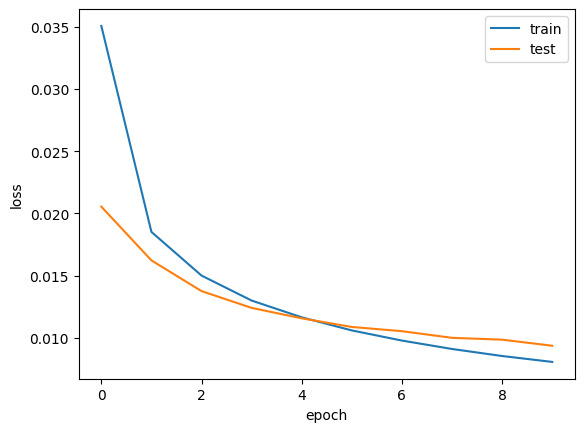

In [21]:
plt.plot(third_network.loss, label='train')
plt.plot(third_network.val_loss, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'acc')

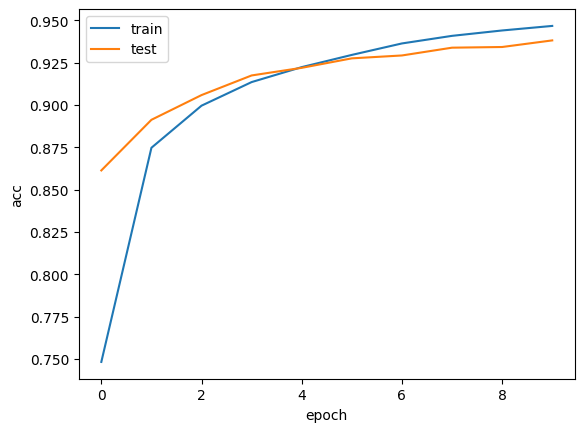

In [22]:
plt.plot(third_network.acc, label='train')
plt.plot(third_network.val_acc, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')

In [5]:
fourth_network = neu.create_neu_network(neu_list = [28*28, 128, 64, 10], 
                                        activ_func_list=['relu', 'sigmoid', 'softmax'], 
                                        loss_func='categorical_crossentropy')
fourth_network.fit(train_images, train_labels, epochs=10, learning_rate=.01, val=(test_images, test_labels))

epoch: 1, loss: [0.51663783], acc: 0.84085
val_loss: [0.32683563], val_acc: 0.9
epoch: 2, loss: [0.28495391], acc: 0.9149166666666667
val_loss: [0.24525219], val_acc: 0.9243
epoch: 3, loss: [0.21975398], acc: 0.9339166666666666
val_loss: [0.22079769], val_acc: 0.9319
epoch: 4, loss: [0.18943107], acc: 0.9426
val_loss: [0.19867436], val_acc: 0.9407
epoch: 5, loss: [0.16681176], acc: 0.9495666666666667
val_loss: [0.17138954], val_acc: 0.9475
epoch: 6, loss: [0.14499058], acc: 0.9559166666666666
val_loss: [0.16994116], val_acc: 0.9475
epoch: 7, loss: [0.13059683], acc: 0.9603333333333334
val_loss: [0.16485549], val_acc: 0.9514
epoch: 8, loss: [0.11489004], acc: 0.9648
val_loss: [0.14831872], val_acc: 0.9541
epoch: 9, loss: [0.10332545], acc: 0.96825
val_loss: [0.1408628], val_acc: 0.9576
epoch: 10, loss: [0.10000096], acc: 0.9685833333333334
val_loss: [0.1492432], val_acc: 0.9568


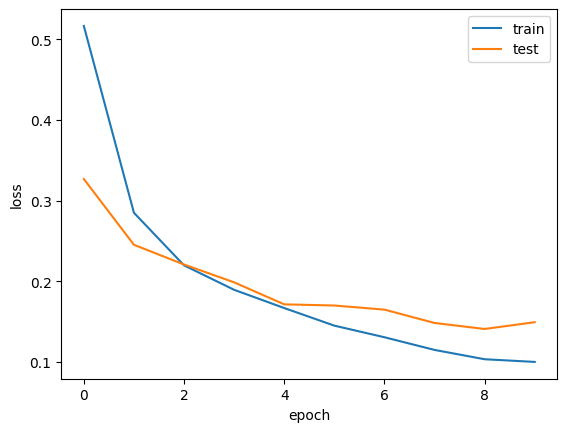

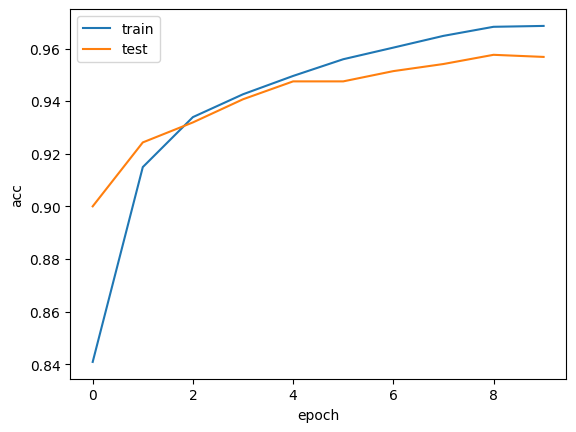

In [7]:
plt.plot(fourth_network.loss, label='train')
plt.plot(fourth_network.val_loss, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.plot(fourth_network.acc, label='train')
plt.plot(fourth_network.val_acc, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()